In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

# %matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
# 定义步长 K
TIME_STEP = 2
INPUT_DIM = 1
output_dim = 1
batch_size = 10  # 每轮训练模型时，样本的数量
epochs = 20  # 训练60轮次
hidden_size = 32
layer_num = 2

In [3]:
chunksize = 10000
reader = pd.read_csv(
    "/data/hmn_data/alibaba_cluster_data/MSRTQps_sort.csv", chunksize=chunksize)


In [4]:
df = pd.DataFrame()
index = 0
# 循环读取每个数据块并添加到DataFrame中
for index, chunk in enumerate(reader):
        if index > 10:
            break
        df = pd.concat([df, chunk])


In [5]:
df.head(100)

,Unnamed: 0,msinstanceid,timestamp,HTTP_MCR,HTTP_RT
0,0,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,0,7.195093,7.195093
1,22430,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,60000,7.118115,7.118115
2,44840,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,120000,6.985224,6.985224
3,67235,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,180000,7.654883,7.654883
4,89612,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,240000,7.217251,7.217251
...,...,...,...,...,...
95,2144226,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,5700000,7.159023,7.159023
96,2166891,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,5760000,6.933686,6.933686
97,2189593,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,5820000,6.938315,6.938315
98,2212252,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,5880000,7.534233,7.534233


In [6]:
def split_array_by_step(arr, k):
    return [arr[i:i+k] for i in range(0, len(arr)-k)]

# 按照 msinstanceid 列分组
grouped_df = df.groupby('msinstanceid')["HTTP_RT"].apply(
    lambda x: split_array_by_step(x, TIME_STEP+1)).reset_index()


In [7]:
combined_df = pd.DataFrame()

# 对于每个分组
for index, row in grouped_df.iterrows():
    if len(row["HTTP_RT"]) > 0:
        combined_df = pd.concat([combined_df, pd.DataFrame(
            np.stack([arr for arr in row["HTTP_RT"]], axis=0))])

print(combined_df.shape)

(109468, 3)


In [8]:
scaler = MinMaxScaler()
workload = scaler.fit_transform(combined_df)

In [9]:
# 将数据转换为LSTM模型的输入形式
def create_sequences(data, time_steps=1):
    xs, ys = [], []
    for i in range(len(data)):
        xs.append(data[i][:time_steps])
        ys.append(data[i][time_steps])
    return np.array(xs), np.array(ys)

x_train, y_train = create_sequences(workload, TIME_STEP)

In [10]:
x_train=np.expand_dims(x_train, axis=2)
y_train=np.expand_dims(y_train, axis=1)

print(x_train.shape)
print(y_train.shape)

(109468, 2, 1)
(109468, 1)


In [11]:
train_size = int(len(x_train) * 0.6)
val_size = int(len(x_train) * 0.2)
test_size = len(x_train) - train_size-val_size

x_train, x_val, x_test = x_train[:train_size, :, :], x_train[train_size:train_size +
                                                             val_size, :, :], x_train[train_size+val_size:, :, :]
y_train, y_val, y_test = y_train[:train_size], y_train[train_size:train_size +
                                                       val_size], y_train[train_size+val_size:]


In [12]:
print(x_train, x_val.shape, x_test.shape)


[[[0.00083767]
  [0.00082869]]

 [[0.00082869]
  [0.00081318]]

 [[0.00081318]
  [0.00089131]]

 ...

 [[0.00100967]
  [0.00100556]]

 [[0.00100556]
  [0.00101698]]

 [[0.00101698]
  [0.000942  ]]] (21893, 2, 1) (21895, 2, 1)


In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out


In [14]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1):
        super(BiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out


In [15]:
class Attention(nn.Module):
    def __init__(self, lstm_hidden_size, attention_size):
        super(Attention, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.attention_size = attention_size
        self.attention_vec = nn.Linear(lstm_hidden_size * 2, attention_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, lstm_out):
        attention_probs = self.sigmoid(self.attention_vec(lstm_out))
        return attention_probs * lstm_out

class LSTM_fun_PyTorch_att(nn.Module):
    def __init__(self, n_input, seq_len, lstm_hidden_size=32, attention_size=64):
        super(LSTM_fun_PyTorch_att, self).__init__()
        self.conv1d = nn.Conv1d(n_input, 32, kernel_size=1)
        self.relu = nn.ReLU()
        self.maxpool1d = nn.MaxPool1d(seq_len)
        self.dropout = nn.Dropout(0.1)
        self.bilstm = nn.LSTM(32, lstm_hidden_size, bidirectional=True)
        self.attention = Attention(lstm_hidden_size, attention_size)
        self.fc = nn.Linear(lstm_hidden_size * 2, 1)

    def forward(self, inputs):
        x = self.conv1d(inputs)
        x = self.relu(x)
        x = self.maxpool1d(x)
        x = self.dropout(x)
        x = x.transpose(1, 2)
        lstm_out, _ = self.bilstm(x)
        attention_mul = self.attention(lstm_out)
        output = self.fc(attention_mul)
        return output.squeeze(-1)


In [16]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, delta=0, verbose=False, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            path (str): Path to save checkpoint.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.trace_func = trace_func
        self.best_loss = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(val_loss, model)
            if self.verbose:
                self.trace_func(f"Validation loss decreased {self.delta:.6f} units or more, saving model.")

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f"Validation loss decreased. Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.best_loss = val_loss

In [17]:
def validate(model, criterion, dataloader):
    running_loss = 0.0
    total_samples = 0

    for batch_x, batch_y in dataloader:
        output = model(batch_x)
        loss = criterion(output, batch_y)

        running_loss += loss.item() * batch_x.size(0)
        total_samples += batch_x.size(0)

    epoch_loss = running_loss / total_samples

    return epoch_loss

In [18]:
def train_model(train_x, train_y, val_x, val_y, model, epochs, batch_size, device, patience=3):
    train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
    train_y = torch.tensor(train_y, dtype=torch.float32).to(device)
    dataset = TensorDataset(train_x, train_y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    val_x = torch.tensor(val_x, dtype=torch.float32).to(device)
    val_y = torch.tensor(val_y, dtype=torch.float32).to(device)
    val_dataset = TensorDataset(val_x, val_y)
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    scheduler = ReduceLROnPlateau(optimizer, patience=1, verbose=True)
    # early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(epochs):
        running_loss = 0.0
        total_samples = 0

        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_x.size(0)
            total_samples += batch_x.size(0)

        epoch_loss = running_loss / total_samples
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.6f}")

        # 在每个epoch后进行验证并检查早停
        with torch.no_grad():
            val_loss = validate(model, criterion, val_dataloader)
            print(f"Validation Loss: {val_loss:.6f}")

            # 更新学习率
            scheduler.step(val_loss)

            # 检查早停
            # early_stopping(val_loss, model)
            # if early_stopping.early_stop:
            #     print("Early stopping")
            #     break

    return model


In [19]:
def predict(model, predict_x, device):
    predict_x = torch.tensor(predict_x, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        y_pred = model(predict_x)
    return y_pred.cpu().numpy()


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lstm_model = LSTMModel(INPUT_DIM, hidden_size,
                       layer_num, output_dim).to(device)

lstm_model_trained = train_model(x_train, y_train, x_val, y_val, lstm_model,
                                 epochs, batch_size, device)

lstm_pred = predict(lstm_model_trained, x_test, device)


Epoch 1/20, Loss: 0.000035
Validation Loss: 0.000174
Epoch 2/20, Loss: 0.000024
Validation Loss: 0.000210
Epoch 3/20, Loss: 0.000022
Validation Loss: 0.000218
Epoch 00003: reducing learning rate of group 0 to 1.0000e-04.
Epoch 4/20, Loss: 0.000020
Validation Loss: 0.000220
Epoch 5/20, Loss: 0.000020
Validation Loss: 0.000222
Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
Epoch 6/20, Loss: 0.000020
Validation Loss: 0.000222
Epoch 7/20, Loss: 0.000020
Validation Loss: 0.000222
Epoch 00007: reducing learning rate of group 0 to 1.0000e-06.
Epoch 8/20, Loss: 0.000020
Validation Loss: 0.000222
Epoch 9/20, Loss: 0.000020
Validation Loss: 0.000222
Epoch 00009: reducing learning rate of group 0 to 1.0000e-07.
Epoch 10/20, Loss: 0.000020
Validation Loss: 0.000222
Epoch 11/20, Loss: 0.000020
Validation Loss: 0.000222
Epoch 00011: reducing learning rate of group 0 to 1.0000e-08.
Epoch 12/20, Loss: 0.000020
Validation Loss: 0.000222
Epoch 13/20, Loss: 0.000020
Validation Loss: 0.0002

In [21]:
bi_lstm_model  = BiLSTMModel(
    INPUT_DIM, hidden_size, layer_num, output_dim).to(device)

bi_lstm_model_trained = train_model(x_train, y_train, x_val, y_val, bi_lstm_model,
                                    epochs, batch_size, device)

bi_lstm_pred = predict(bi_lstm_model_trained, x_test, device)


Epoch 1/20, Loss: 0.000036
Validation Loss: 0.000175
Epoch 2/20, Loss: 0.000023
Validation Loss: 0.000213
Epoch 3/20, Loss: 0.000022
Validation Loss: 0.000230
Epoch 00003: reducing learning rate of group 0 to 1.0000e-04.
Epoch 4/20, Loss: 0.000020
Validation Loss: 0.000234
Epoch 5/20, Loss: 0.000020
Validation Loss: 0.000227
Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
Epoch 6/20, Loss: 0.000020
Validation Loss: 0.000228
Epoch 7/20, Loss: 0.000020
Validation Loss: 0.000229
Epoch 00007: reducing learning rate of group 0 to 1.0000e-06.
Epoch 8/20, Loss: 0.000020
Validation Loss: 0.000229
Epoch 9/20, Loss: 0.000020
Validation Loss: 0.000229
Epoch 00009: reducing learning rate of group 0 to 1.0000e-07.
Epoch 10/20, Loss: 0.000020
Validation Loss: 0.000229
Epoch 11/20, Loss: 0.000020
Validation Loss: 0.000229
Epoch 00011: reducing learning rate of group 0 to 1.0000e-08.
Epoch 12/20, Loss: 0.000020
Validation Loss: 0.000229
Epoch 13/20, Loss: 0.000020
Validation Loss: 0.0002

In [28]:
attention_model = LSTM_fun_PyTorch_att(INPUT_DIM, TIME_STEP).to(device)

# Reshape the data to match the expected input format of nn.Conv1d
attention_x_train = np.transpose(x_train, (0, 2, 1))
attention_x_val = np.transpose(x_val, (0, 2, 1))
attention_x_test = np.transpose(x_test, (0, 2, 1))

attention_model_trained = train_model(attention_x_train, y_train, attention_x_val, y_val, attention_model,
                                      epochs, batch_size, device)

attention_pred = predict(attention_model_trained, attention_x_test, device)


Epoch 1/20, Loss: 0.000052
Validation Loss: 0.000180
Epoch 2/20, Loss: 0.000029
Validation Loss: 0.000218


KeyboardInterrupt: 

In [ ]:
# MSE
criterion = nn.MSELoss()

lstm_pred_tensor = torch.tensor(lstm_pred)
bi_lstm_pred_tensor = torch.tensor(bi_lstm_pred)
attention_pred_tensor = torch.tensor(attention_pred)
y_test_tensor = torch.tensor(y_test)


val_loss = criterion(lstm_pred_tensor, y_test_tensor)
print("Validation Loss: {:.6f}".format(val_loss.item()))

val_loss = criterion(bi_lstm_pred_tensor, y_test_tensor)
print("Validation Loss: {:.6f}".format(val_loss.item()))

val_loss = criterion(attention_pred_tensor, y_test_tensor)
print("Validation Loss: {:.6f}".format(val_loss.item()))


# MAE
criterion = nn.L1Loss()

val_loss = criterion(lstm_pred_tensor, y_test_tensor)
print("Validation Loss: {:.6f}".format(val_loss.item()))

val_loss = criterion(bi_lstm_pred_tensor, y_test_tensor)
print("Validation Loss: {:.6f}".format(val_loss.item()))

val_loss = criterion(attention_pred_tensor, y_test_tensor)
print("Validation Loss: {:.6f}".format(val_loss.item()))


# MAPE
pct_error = 100.0 * \
    torch.abs((lstm_pred_tensor - y_test_tensor) /
              y_test_tensor)
print("Validation Loss: {:.6f}".format(torch.mean(pct_error)))

pct_error = 100.0 * \
    torch.abs((bi_lstm_pred_tensor -
              y_test_tensor) / y_test_tensor)
print("Validation Loss: {:.6f}".format(torch.mean(pct_error)))

pct_error = 100.0 * \
    torch.abs((attention_pred_tensor -
              y_test_tensor) / y_test_tensor)
print("Validation Loss: {:.6f}".format(torch.mean(pct_error)))


Validation Loss: 0.000012
Validation Loss: 0.000011
Validation Loss: 0.000015
Validation Loss: 0.001325
Validation Loss: 0.001279
Validation Loss: 0.001910
Validation Loss: inf
Validation Loss: inf
Validation Loss: inf


In [ ]:
import numpy as np
import numba
import cupy as cp
from statsmodels.tsa.arima.model import ARIMA

def arima_predict(train_data, p=2, d=1, q=2):
        # 设置ARIMA模型参数
        # AR阶数
        # 差分阶数
        # MA阶数

        predict = []

        for item in train_data:
            model = ARIMA(item, order=(p, d, q))
            model_fit = model.fit()
            res = model_fit.forecast(steps=1)
            predict.append(res)

        return np.array(predict)

arima_pred= arima_predict(x_test)

/home/lwh/miniconda3/envs/service_workload/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lwh/miniconda3/envs/service_workload/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lwh/miniconda3/envs/service_workload/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lwh/miniconda3/envs/service_workload/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

LinAlgError: LU decomposition error.

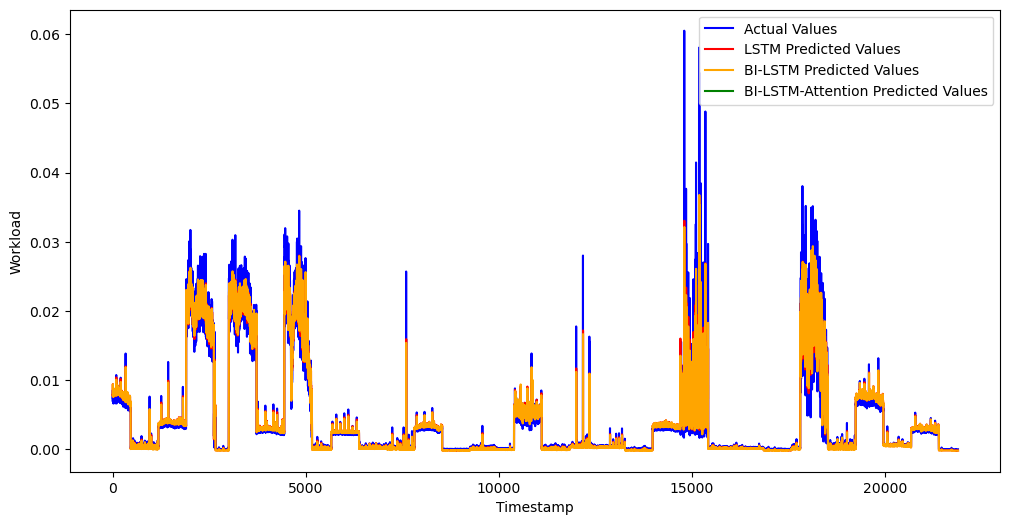

In [30]:
arima_pred=[]

def plot_predictions(y_test, y_pre_arima, y_pred_lstm, y_pred_bi_lstm, y_pred_attention):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label="Actual Values", color='blue')
    # plt.plot(y_pre_arima, label="ARIMA Predicted Values", color='pink')
    plt.plot(y_pred_lstm, label="LSTM Predicted Values", color='red')
    plt.plot(y_pred_bi_lstm, label="BI-LSTM Predicted Values", color='orange')
    plt.plot(y_pred_attention,
             label="BI-LSTM-Attention Predicted Values", color='green')

    plt.xlabel("Timestamp")
    plt.ylabel("Workload")
    plt.legend()
    plt.show()


plot_predictions(y_test, arima_pred, lstm_pred, bi_lstm_pred, attention_pred)


In [ ]:
y_test = y_test.squeeze()
# arima_pred = arima_pred.squeeze()
lstm_pred = lstm_pred.squeeze()
bi_lstm_pred = lstm_pred.squeeze()
attention_pred = lstm_pred.squeeze()

# 将这些数组组合成一个DataFrame对象
df = pd.concat([pd.Series(y_test).reindex(range(max(map(len, [y_test, lstm_pred, lstm_pred, bi_lstm_pred, attention_pred]))), fill_value=np.nan),
                pd.Series(arima_pred).reindex(range(max(map(len, [
                    y_test, lstm_pred, lstm_pred, bi_lstm_pred, attention_pred]))), fill_value=np.nan),
                pd.Series(lstm_pred).reindex(range(max(map(len, [
                    y_test, lstm_pred, lstm_pred, bi_lstm_pred, attention_pred]))), fill_value=np.nan),
                pd.Series(bi_lstm_pred).reindex(range(max(map(len, [
                    y_test, lstm_pred, lstm_pred, bi_lstm_pred, attention_pred]))), fill_value=np.nan),
                pd.Series(attention_pred).reindex(range(max(map(len, [
                    y_test, lstm_pred, lstm_pred, bi_lstm_pred, attention_pred]))), fill_value=np.nan),
                ], axis=1)

# 将DataFrame对象写入CSV文件
df.to_csv('./my_data.csv', index=False)

/tmp/ipykernel_27914/1204313056.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(arima_pred).reindex(range(max(map(len, [


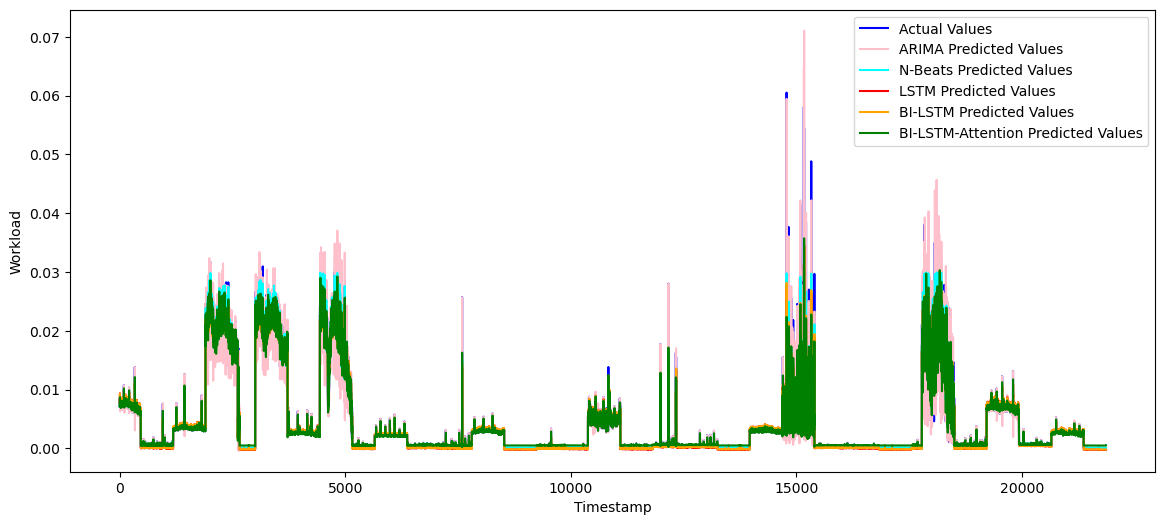

ARIMA MAE Validation Loss: 29.117861
N-Beats MAE Validation Loss: 336.338902


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import torch


data = pd.read_csv('../../data/model/2023-4-21-1/result.csv')

plt.figure(figsize=(14, 6))
plt.plot(data["0"], label="Actual Values", color='blue')
plt.plot(data["1"], label="ARIMA Predicted Values", color='pink')
plt.plot(data["2"], label="N-Beats Predicted Values", color='aqua')
plt.plot(data["3"], label="LSTM Predicted Values", color='red')
plt.plot(data["4"], label="BI-LSTM Predicted Values", color='orange')
plt.plot(data["5"], label="BI-LSTM-Attention Predicted Values", color='green')

plt.xlabel("Timestamp")
plt.ylabel("Workload")
plt.legend()
plt.show()

tmp = (torch.tensor(data["1"]) -
       torch.tensor(data["0"])) / torch.tensor(data["0"])

isinf = torch.isinf(tmp)
tmp = torch.masked_select(tmp, ~isinf)

pct_error = 100.0 * \
    torch.abs(tmp)
print("ARIMA MAE Validation Loss: {:.6f}".format(torch.mean(pct_error)))


tmp = (torch.tensor(data["5"]) -
       torch.tensor(data["0"])) / torch.tensor(data["0"])
isinf = torch.isinf(tmp)
tmp = torch.masked_select(tmp, ~isinf)

pct_error = 100.0 * \
    torch.abs(tmp)
print("N-Beats MAE Validation Loss: {:.6f}".format(torch.mean(pct_error)))